<center>
<img src="../../img/ods_stickers.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko) 

# <center>Assignment #3. Spring 2019
## <center> Part 3. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 

### Your task is to:
 1. beat **"A3 baseline (8 credits)"** on Public LB (**0.73449** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with the course rating
 
 This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A3: 2019 March 31, 20:59 GMT (London time)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns
from catboost import CatBoostClassifier

In [2]:
import lightgbm as lgb

Download data from the [competition page](https://www.kaggle.com/c/flight-delays-fall-2018/data) and change paths if needed.

In [3]:
train_df = pd.read_csv('../../data/flight_delays_train.csv')
test_df = pd.read_csv('../../data/flight_delays_test.csv')

In [4]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take logistic regression and two features that are easiest to take: DepTime and Distance. This will correspond to **"simple logit baseline"** on Public LB.

In [6]:
X_train = train_df[['Distance', 'DepTime']].values 
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [7]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [8]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795691465352607

In [9]:
logit_pipe.fit(X_train, y_train)
logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('logit_2feat.csv', 
                                           index_label='id', header=True)  # 0.68202

Now you have to beat **"A3 baseline (8 credits)"** on Public LB. It's not challenging at all. Go for LightGBM, maybe some other models (or ensembling) as well. Include categorical features, do some simple feature engineering as well. Good luck!

In [80]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

# Ideas

In [88]:
train_df = pd.read_csv('../../data/flight_delays_train.csv')
test_df = pd.read_csv('../../data/flight_delays_test.csv')

In [84]:
# extract hour and minute and remove deptime

def extraction_hour(a):
    size = len(str(a))
    if(a >= 2400):
        return 0 # we assume that over 24:00h, it is an outlier and it is replaced by 24h
    if size == 4: 
        return int(str(a)[:2])
    elif(size == 3):
        return int(str(a)[:1])
    else:
        return 0
    
def extraction_minutes(a):
    size = len(str(a))
    
    if size == 4: 
        return int(str(a)[2:4])
    elif(size == 3):
        return int(str(a)[1:3])
    elif(size == 2):
        return int(str(a)[0:2])
    else:
        return int(str(a)[0])

def time_features(df):
    df['DepHour'] = df.DepTime.apply(extraction_hour)
    df['DepMinute'] = df.DepTime.apply(extraction_minutes)
    return df#.drop(['DepTime'], axis=1)

def datetime_features_to_int(df):
    df.Month = df.Month.apply(lambda e: int(e.split("-")[1]))
    df.DayofMonth = df.DayofMonth.apply(lambda e: int(e.split("-")[1]))
    df.DayOfWeek = df.DayOfWeek.apply(lambda e: int(e.split("-")[1]))
    df['isWeekend'] = pd.Series([1 if (x > 5) & (x < 2) else 0 for x in df.DayOfWeek])
    return df

    

# EDA

In [11]:
train_df.shape

(100000, 9)

In [12]:
test_df.shape

(100000, 8)

In [85]:
train_df.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [89]:
train_df = time_features(train_df)
train_df = datetime_features_to_int(train_df)

# Univariate analysis

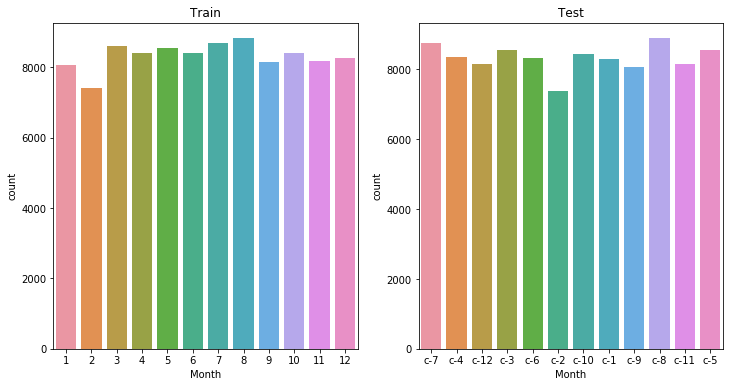

In [94]:

plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(train_df.Month)
plt.title("Train")
plt.xlabel('Month')
          
plt.subplot(1, 2, 2)
sns.countplot(test_df.Month)
plt.title('Test')
plt.xlabel('Month');


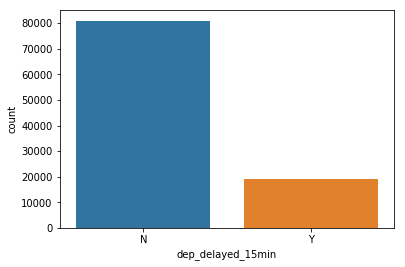

In [90]:
# output feature
sns.countplot(train_df.dep_delayed_15min) # high imbalanced ratio

# Bivariate analysis

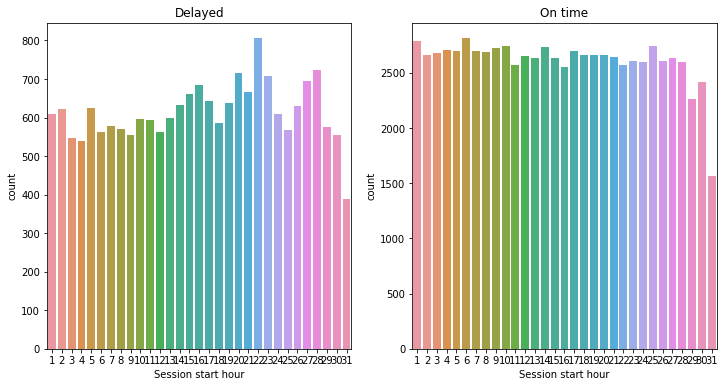

In [91]:
# features vs. output


plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(train_df[train_df.dep_delayed_15min == 'Y'].DayofMonth)
plt.title("Delayed")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(train_df[train_df.dep_delayed_15min == 'N'].DayofMonth)
plt.title('On time')
plt.xlabel('Session start hour');


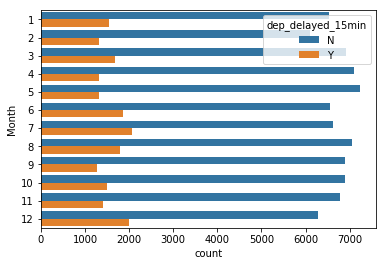

In [92]:
# features vs. output
sns.countplot(y="Month", hue="dep_delayed_15min", data = train_df)


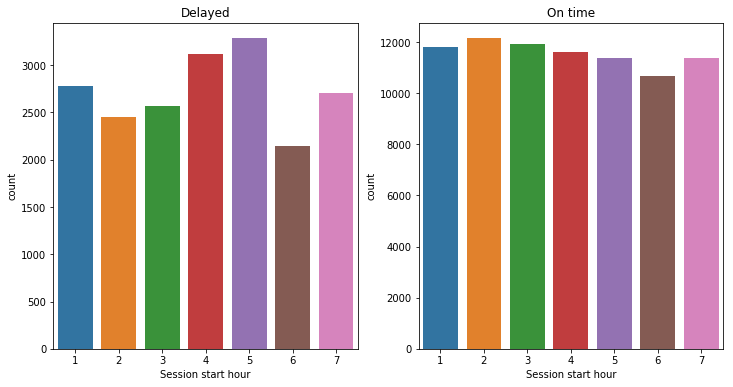

In [95]:
# features vs. output
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(train_df[train_df.dep_delayed_15min == 'Y'].DayOfWeek)
plt.title("Delayed")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(train_df[train_df.dep_delayed_15min == 'N'].DayOfWeek)
plt.title('On time')
plt.xlabel('Session start hour');

# seems fridays are bad to take a plane, whereas saturdays are good

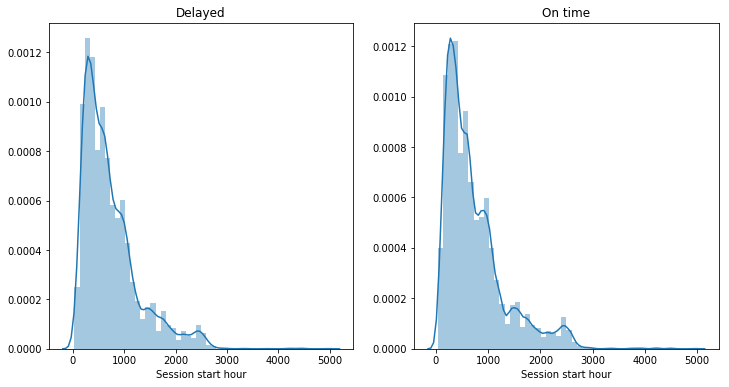

In [96]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.distplot(train_df[train_df.dep_delayed_15min == 'Y'].Distance)
plt.title("Delayed")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.distplot(train_df[train_df.dep_delayed_15min == 'N'].Distance)
plt.title('On time')
plt.xlabel('Session start hour');

# not big difference

In [21]:
train_df.dep_delayed_15min.value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

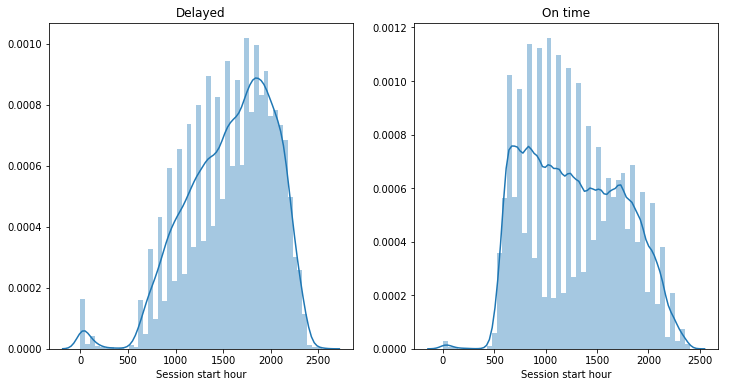

In [98]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.distplot(train_df[train_df.dep_delayed_15min == 'Y'].DepTime)
plt.title("Delayed")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.distplot(train_df[train_df.dep_delayed_15min == 'N'].DepTime)
plt.title('On time')
plt.xlabel('Session start hour');

# clearly more delays at the end of the day

# Outliers

In [25]:
test_df.Distance.max() # weird too much distance

4962

In [26]:
train_df[train_df.Distance == 4962]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
18013,c-7,c-12,c-2,1325,CO,EWR,HNL,4962,N
23106,c-1,c-1,c-6,2310,CO,HNL,EWR,4962,Y
30874,c-11,c-16,c-4,1355,CO,EWR,HNL,4962,Y
43630,c-5,c-16,c-2,2118,CO,HNL,EWR,4962,N
52432,c-10,c-3,c-2,2124,CO,HNL,EWR,4962,N
73813,c-8,c-27,c-6,2128,CO,HNL,EWR,4962,N
81471,c-3,c-7,c-2,2237,CO,HNL,EWR,4962,N
81662,c-5,c-15,c-7,2126,CO,HNL,EWR,4962,N
89043,c-3,c-23,c-4,2247,CO,HNL,EWR,4962,N
89269,c-6,c-10,c-5,2129,CO,HNL,EWR,4962,N


In [27]:
train_df.Distance.max() # It seems that there is a flight with this real distance

4962

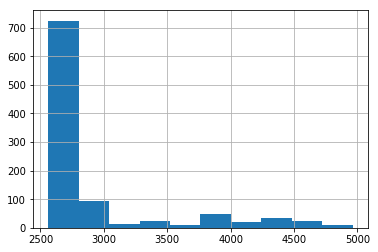

In [28]:
train_df[train_df.Distance > 2556].Distance.hist()

In [29]:
train_df.nunique()

Month                  12
DayofMonth             31
DayOfWeek               7
DepTime              1300
UniqueCarrier          22
Origin                289
Dest                  289
Distance             1310
dep_delayed_15min       2
dtype: int64

In [30]:
test_df.nunique()

Month              12
DayofMonth         31
DayOfWeek           7
DepTime          1287
UniqueCarrier      20
Origin            300
Dest              298
Distance         1331
dtype: int64

In [31]:


deleted_carriers = set(train_df.UniqueCarrier) - set(test_df.UniqueCarrier)
deleted_carriers

{'DH', 'HP', 'TZ'}

In [32]:
train_df[train_df.UniqueCarrier.isin(deleted_carriers)].shape[0]

2790

In [33]:
new_carriers = set(test_df.UniqueCarrier) - set(train_df.UniqueCarrier)
new_carriers
# new carriers on both sides

{'9E'}

In [34]:
test_df[test_df.UniqueCarrier.isin(new_carriers)].shape[0] / test_df.shape[0] # not a big deal

0.03461

In [35]:
test_df[test_df.UniqueCarrier.isin(new_carriers)].head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
36,c-10,c-27,c-6,1523,9E,DTW,BHM,625
40,c-1,c-7,c-7,1255,9E,MSN,DCA,707
80,c-1,c-14,c-7,1447,9E,OMA,MSP,282
151,c-11,c-2,c-5,1834,9E,MEM,CMH,518
179,c-2,c-24,c-6,1455,9E,CVG,DTW,229


In [36]:
set(train_df.Origin) - set(test_df.Origin)

{'CDC', 'HKY', 'HVN', 'ISO', 'PIE', 'VCT', 'VIS'}

In [37]:
set(train_df.Dest) - set(test_df.Dest)

{'CDC', 'GST', 'HKY', 'HVN', 'ISO', 'PIE', 'TEX', 'VCT', 'VIS'}

In [38]:
new_origins = (set(test_df.Origin) - set(train_df.Origin)) 
new_origins
# bad news, be aware with overfitting

{'ALO',
 'BJI',
 'CMX',
 'EAU',
 'ELM',
 'EWN',
 'HHH',
 'INL',
 'MTH',
 'PLN',
 'PMD',
 'RHI',
 'ROW',
 'SLE',
 'SOP',
 'SUX',
 'TTN',
 'YKM'}

In [39]:
new_dests = (set(test_df.Dest) - set(train_df.Dest))
new_dests

{'ADK',
 'ALO',
 'BJI',
 'CMX',
 'EAU',
 'ELM',
 'EWN',
 'HHH',
 'INL',
 'MTH',
 'OAJ',
 'PLN',
 'PMD',
 'RHI',
 'ROW',
 'SLE',
 'SUX',
 'YKM'}

In [40]:
test_df[test_df.Origin.isin(new_origins)].shape # not a big deal, but still worrying

(99, 8)

In [41]:
test_df[test_df.Origin.isin(new_origins)].head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
4295,c-9,c-19,c-3,626,EV,EWN,ATL,433
5599,c-8,c-20,c-1,1547,9E,ELM,DTW,331
6080,c-5,c-30,c-3,701,9E,CMX,MSP,277
6941,c-9,c-20,c-4,612,9E,PLN,DTW,243
7349,c-7,c-5,c-4,621,OO,YKM,SLC,586


In [42]:
train_df.isnull().sum(axis=0).sum() + test_df.isnull().sum(axis=0).sum() # No NaNs

0

In [43]:
# check distances are maintained across the same traject
all_df = pd.concat([train_df, test_df])
all_df['traject'] = all_df.apply(lambda x: '%s-%s' % (x['Origin'], x['Dest']), axis=1)
train_df['traject'] = train_df.apply(lambda x: '%s-%s' % (x['Origin'], x['Dest']), axis=1)

all_df.groupby('traject').Distance.nunique().value_counts()

1    5048
Name: Distance, dtype: int64

In [44]:
all_df.dtypes

DayOfWeek            object
DayofMonth           object
DepTime               int64
Dest                 object
Distance              int64
Month                object
Origin               object
UniqueCarrier        object
dep_delayed_15min    object
traject              object
dtype: object

In [45]:
train_df['target'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

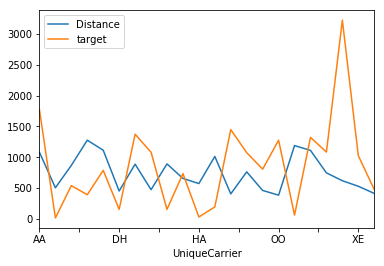

In [46]:
train_df.groupby('UniqueCarrier').agg({'Distance': np.mean, 'target': np.sum}).plot()

# seems no relationship among mean distance and target

In [47]:
train_df.groupby('UniqueCarrier').agg({'Distance': np.mean, 'target': np.sum})

,Distance,target
UniqueCarrier,,
AA,1079.926630,1770
AQ,506.307692,18
AS,868.553555,541
B6,1276.878128,393
CO,1113.829257,788
DH,453.467909,156
DL,888.395423,1373
EV,475.270483,1082
F9,892.682903,156


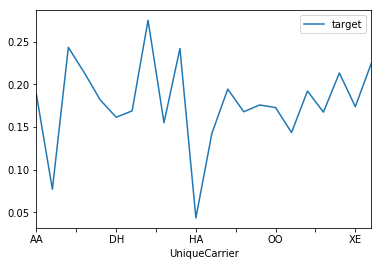

In [48]:
train_df.groupby('UniqueCarrier').agg({'target': np.mean}).plot()

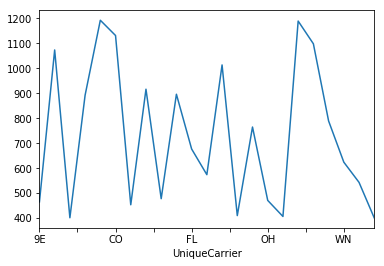

In [49]:
stats_mean_distance_carrier = all_df.groupby('UniqueCarrier').Distance.mean()
stats_mean_distance_carrier.plot()

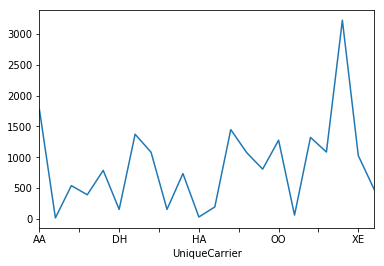

In [50]:
stats_mean_distance_carrier = train_df.groupby('UniqueCarrier').target.sum()
stats_mean_distance_carrier.plot()

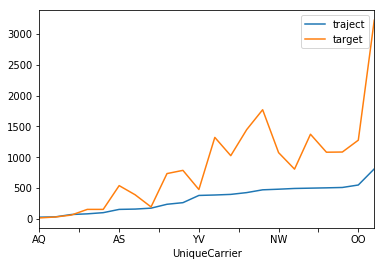

In [51]:
# check flights per carrier
train_df['traject'] = train_df.apply(lambda x: '%s-%s' % (x['Origin'], x['Dest']), axis=1)

ntraject_per_carrier = train_df.groupby('UniqueCarrier').agg({'traject': pd.Series.nunique, 'target': sum}).sort_values('traject', ascending=True)
ntraject_per_carrier.plot()

# more trajects imply more troubles

In [53]:
tmp = time_features(train_df)
tmp = datetime_features_to_int(tmp)

In [54]:
tmp.groupby('DepTime').agg({'target': lambda x: len(x)}).describe()
# repetitions in deptime

,target
count,1300.000000
mean,76.923077
std,51.499204
min,1.000000
25%,36.000000
50%,80.000000
75%,97.000000
max,359.000000


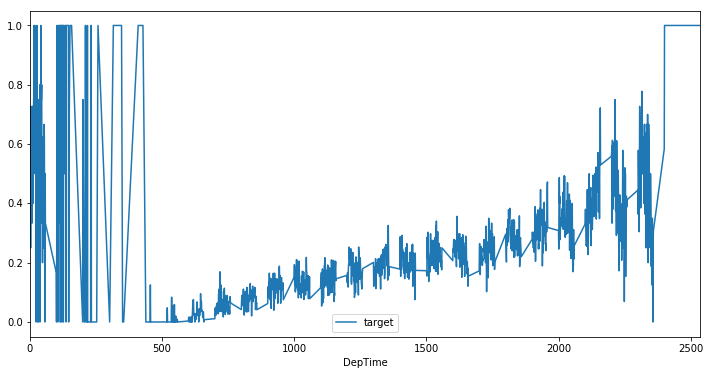

In [55]:
tmp.groupby('DepTime').agg({'target': lambda x: sum(x) / len(x)}).plot(figsize=(12,6))

# Dept time is very influent on target, but is unconfident during the first hours

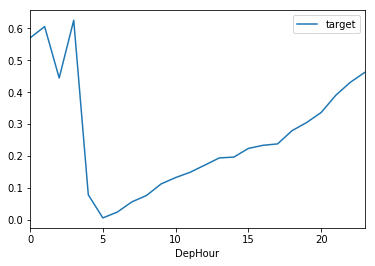

In [56]:
tmp.groupby('DepHour').agg({'target': lambda x: sum(x) / len(x)}).plot()

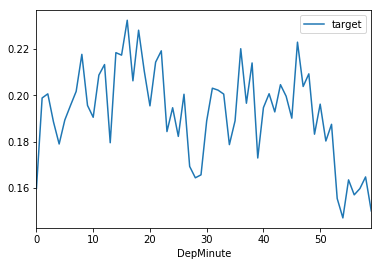

In [57]:
tmp.groupby('DepMinute').agg({'target': lambda x: sum(x) / len(x)}).plot()

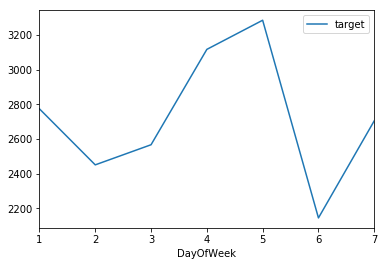

In [58]:
# check flights per carrier
train_df.groupby('DayOfWeek').agg({'target': sum}).plot()

In [59]:
train_df.groupby('traject').agg({'DepTime': np.mean, 'target': lambda x: sum(x) / len(x)}).sort_values('target', ascending=False)[:10]

,DepTime,target
traject,,
DCA-ROC,1773.333333,1.0
ATL-CID,2312.000000,1.0
CID-ATL,728.000000,1.0
DEN-GRR,1103.000000,1.0
TPA-RIC,1338.000000,1.0
RSW-CMH,1442.500000,1.0
JFK-CHS,2330.000000,1.0
GRB-DFW,1437.000000,1.0
BOS-TTN,1005.000000,1.0


In [61]:
date_strings = '2018-' + tmp['Month'].map(str) + "-" + tmp['DayofMonth'].map(str)
tmp['day_and_month'] = pd.to_datetime(date_strings)
tmp['day_and_month_str'] = tmp.day_and_month.apply(lambda x: x.strftime('%Y-%m-%d'))
tmp.day_and_month_str.head()

0    2018-08-21
1    2018-04-20
2    2018-09-02
3    2018-11-25
4    2018-10-07
Name: day_and_month_str, dtype: object

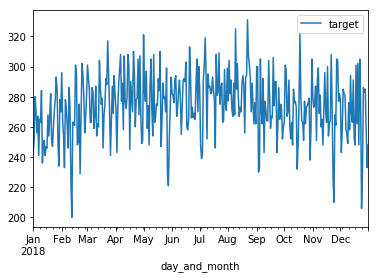

In [65]:
tmp.groupby('day_and_month').agg({'target': len}).plot()

# good representations of day and month, among 320 registers and 200

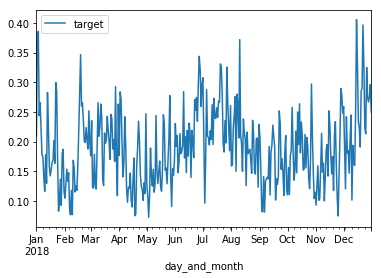

In [66]:
stats = tmp.groupby('day_and_month').agg({'target': lambda x: sum(x) / len(x)}).sort_index()
stats.plot()

# percentages per day_month (there are some peaks, let's check them)

In [70]:
tmp.shape

(100000, 16)

In [ ]:
tmp[]

In [69]:
# All tracjets are performed by the same company?
tmp.groupby('traject').UniqueCarrier.nunique().value_counts() # it seems can be useful to distinguish among traject-companies



1    2655
2    1054
3     473
4     197
5      32
6      10
7       6
9       2
Name: UniqueCarrier, dtype: int64

In [71]:
# Unique carrier + origin/dest
tmp['Carrier_Origin'] = tmp.apply(lambda x: '%s-%s' % (x['UniqueCarrier'], x['Origin']), axis=1)
tmp['Carrier_Dest'] = tmp.apply(lambda x: '%s-%s' % (x['UniqueCarrier'], x['Dest']), axis=1)
tmp['Carrier_Traject'] = tmp.apply(lambda x: '%s-%s' % (x['UniqueCarrier'], x['traject']), axis=1)

In [76]:
tmp.groupby('Carrier_Origin').target.apply(lambda x: sum(x) / len(x)).sort_values(ascending=False).head()

Carrier_Origin
EV-CID    1.0
OH-ILM    1.0
CO-GSO    1.0
OH-SHV    1.0
AS-GST    1.0
Name: target, dtype: float64

In [101]:
# Read from airports.csv

airports = pd.read_csv('/home/sramirez/Descargas/airports.csv')

airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR
